## ディリクレ過程混合ガウスモデル(DPGMM)の実装

中華料理店過程を使ってディリクレ過程を表現した。

なお、現在のsk-learnでDPGMMのライブラリーは存在するが、stick-breaking表現での実装となっている。

### モデル

$i = 1, \dots, n$ において、
$$
x_i \sim N(\theta_i , \tau^{-1} I)
$$

$$
\theta_i = \begin{cases}
            \mu_k \hspace{15pt} (k = 1, 2, \dots , K^+) \quad \frac{n_k^{\backslash i}}{n - 1 + \alpha} の確率 \\
            \mu_{K^+ + 1} \sim N(\mu_0 , \tau^{-1} I) \quad \frac{\alpha}{n - 1 + \alpha} の確率 \\
    \end{cases}
$$

$$
z_i = k \\
\mu_k \sim N(\mu_0, (\rho_0 \tau)^{-1} I) \\
\tau \sim Ga(a_0, b_0)
$$

### アルゴリズム

(1) $z_i = 1 \hspace{5pt}(i = 1, \dots n)$ で初期化する.

(2) ハイパーパラメータは$ \mu_0 = \vec{0}, \rho_0 = 1, a_0 = 1, b_0 = 1$ で設定する.

(3) $\mu_1$ と $\tau$ をランダムで初期化する.

(4) 以下ⅰ~ⅲを $s = 1, \dots, S$ 回繰り返す.

ⅰ. $p(z_i = k | x_{1:n}) = \begin{cases}
            p(x_i | \mu_k, \tau) \frac{n_k^{\backslash i}}{n - 1 + \alpha} \hspace{9pt} \quad \textrm{if} \hspace{9pt} k = 1, 2, \dots , K^+ \\
            p(x_i | \mu_k, \tau) \frac{\alpha}{n - 1 + \alpha} \hspace{9pt} \quad \textrm{if} \hspace{9pt} k = K^+ + 1\\
    \end{cases}$ 
から $z_i (i = 1, \dots, n)$ をサンプリングする. <br>
ただし, $k = K^+ + 1$ のときは $\mu_k \sim N(\mu_0, (\tau \rho_0)^{-1}I)$ から $\mu_k$ を新しく生成する.

ⅱ. $p(\mu_k | x_{1:n}, z_{1:n}, \tau, \mu_0, \rho_0) = N \left( \mu_k | \frac{n_k}{n_k + \rho_0} \bar{x}_k + \frac{\rho_0}{n_k + \rho_0} \mu_0, (\tau(n_k + \rho_0))^{-1} I \right) $ から $\mu_k (k = 1, \dots, K^+)$ をサンプリングする.

ⅲ. 

$$
\begin{eqnarray*}
& & p(\tau | x_{1:n}, z_{1:n}, \mu_0, \rho_0, a_0, b_0) \\
&=&
Ga \left( \tau {\Large|} a_0 + \frac{nD}{2}, 
b_0 + \sum_{k = 1}^{K^+} \left( \frac{1}{2} \sum_{i = 1}^{n} \delta(z_i = k) \| x_i - \bar{x}_k \| ^2 
+ \frac{n_k \rho_0}{2(\rho_0 + n_k} \| \bar{x}_k - \mu_0 \| ^2 \right) \right)
\end{eqnarray*}
$$

から $\tau$ をサンプリングする.



### ライブラリー

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

### データ

今回のモデルは、混合正規分布のそれぞれの分散共分散行列を全て対角行列として仮定している。

そのため、この仮定のもとでシミュレーションデータを作る。

In [2]:
#2変量正規
#平均ベクトルと共分散行列
np.random.seed(1)
n1 = 40
n2 = 50
n3 = 60
true_mu1 = [30, 30]
true_mu2 = [0, -50]
true_mu3 = [-40, 30]

true_sigma1 = np.array([200,0,0,150]).reshape([2,2])
true_sigma2 = np.array([200,0,0,200]).reshape([2,2])
true_sigma3 = np.array([100,0,0,300]).reshape([2,2])

#2次元正規乱数
MN1 = np.random.multivariate_normal(true_mu1, true_sigma1, n1)
MN2 = np.random.multivariate_normal(true_mu2, true_sigma2, n2)
MN3 = np.random.multivariate_normal(true_mu3, true_sigma3, n3)

data_X = np.vstack([MN1,MN2,MN3])
true_z = np.hstack([np.full(n1,1),np.full(n2,2),np.full(n3,3)])

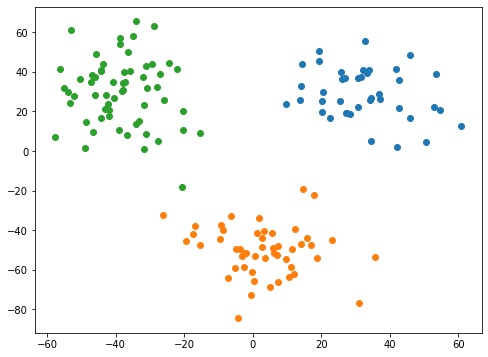

In [3]:
#グラフをプロット
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(MN1[:,0],MN1[:,1], 'o')
ax.plot(MN2[:,0],MN2[:,1], 'o')
ax.plot(MN3[:,0],MN3[:,1], 'o')

### DPGMMの実装

In [4]:
class DPGMM:
    def __init__(self,alpha=1,mu0=0,rho0=1,a0=1,b0=1,burnin=100,max_iter=100):
        self.alpha = alpha
        self.rho0 = rho0
        self.a0 = a0
        self.b0 = b0
        self.max_iter = max_iter
        self.burnin = burnin
        self.mu0 = mu0
    
    def _init_z(self):
        z = []
        for i in range(self._N):
            z.append(0)
        return np.array(z)
    
    def _init_gamma(self):
        return np.random.gamma(self.a0, 1 / self.b0)
    
    def _init_mu(self):
        return np.random.multivariate_normal(self.mu0_vector, self.Sigma, 1)[0]
    
    def _sample_z(self):
        for i in range(self._N):
            z_minus_i = np.delete(self.z,i)                
            prob_k_list = []
                        
            for k in range(self.n):
                p_zi = np.count_nonzero(z_minus_i == k)
                prob_k_list.append(self._Gaussian_pdf(self._X[i], self.mu[k], self.Sigma) * p_zi)

            #new_claster            
            mu_new_k = self._init_mu()
            p_zi = self.alpha

            prob_k_list.append(self._Gaussian_pdf(self._X[i], mu_new_k, self.Sigma) * p_zi)

            # zを決める
            prob_k_list = np.array(prob_k_list)
            prob_k_list = prob_k_list / np.sum(prob_k_list)            
            self.z[i] = np.random.multinomial(1,prob_k_list,size = 1).argmax()
            
            # 新しいクラスターが選択された場合、mu_kを新しく作る
            if self.z[i] == self.n:
                self.n += 1
                self.mu.append(mu_new_k)
            
    def _sample_mu(self):
        for k in range(self.n):
            if k in self.z:
                x_bar = np.mean(self._X[self.z == k], axis = 0)
                nk = np.count_nonzero(self.z == k)
                mean = (nk / (nk + self.rho0)) * x_bar + (self.rho0 / (nk + self.rho0)) * self.mu0_vector
                cov = (1.0 / (self.gamma * (nk + self.rho0))) * np.eye(self._D)
                self.mu[k] = np.random.multivariate_normal(mean, cov, 1)[0]
                
    def _sample_gamma(self):
        a = self.a0 + (self._N * self._D)/2.0
        b = self.b0
        for k in range(self.n):
            if k in self.z:
                x_bar = np.mean(self._X[self.z == k], axis = 0)
                nk = np.count_nonzero(self.z == k)
                b += 0.5 * np.sum(np.linalg.norm(self._X[self.z == k] - x_bar,axis=1) ** 2)
                
                b += (0.5 * (nk * self.rho0) / (self.rho0 + nk)) * np.linalg.norm(x_bar - self.mu0_vector) ** 2
                
        self.gamma = np.random.gamma(a, 1.0 / b)
        self.Sigma = (1.0/(self.rho0*self.gamma)) * np.eye(self._D)

    
    def _Gaussian_pdf(self,x,mu,Sigma):
        g = -0.5 * ((x - mu) @ np.linalg.inv(Sigma) @ (x - mu).T)
        
        exp_g = np.exp(g) #/ np.linalg.det(sigma)

        return exp_g
    
    def _delete_empty_claster(self):
        # 使われていないクラスターは削除する
        k = 0
        while k < self.n:
            if np.count_nonzero(self.z == k) == 0:
                del self.mu[k]
                self.z = np.where(self.z > k, self.z - 1, self.z)
                self.n -= 1
            k += 1

    def fit(self, X):
        self._X = X
        self._N = X.shape[0]
        self._D = X.shape[1]
        self.z = self._init_z()

        self.mu0_vector = np.full(self._D, self.mu0)
        self.gamma = self._init_gamma()
        self.Sigma = (1.0/(self.rho0*self.gamma)) * np.eye(self._D)
        
        #self.n is number of claster
        self.n = 1
        self.mu = [self._init_mu()]
        
        self.trace_gamma = np.zeros(self.max_iter)
        self.trace_z = np.zeros([self.max_iter,self._N])
        
        for i in range(self.max_iter + self.burnin):
            self._sample_z()
            self._delete_empty_claster()
            self._sample_mu()
            self._sample_gamma()
            
            if i >= self.burnin:
                self.trace_gamma[i - self.burnin] = self.gamma
                self.trace_z[i - self.burnin] = self.z
        
        return self
        
    def pred_z(self, X):
        # 新しいデータXに対して予測値を出力する
        N = X.shape[0]
        D = X.shape[1]
        pred_z = np.zeros(N)
        for i in range(N):
            pred_list = []
            for k in range(self.n):
                #nkはselfでいいかも
                nk = np.count_nonzero(self.z == k)
                pred_list.append(self._Gaussian_pdf(X[i], self.mu[k], self.Sigma) * nk)
            
            pred_list = np.array(pred_list)
            # 確率が最大になるクラスターをzにする
            pred_z[i] = pred_list.argmax()
        
        return pred_z

### 推定

データをそのまま突っ込むとオーバーフローしたので、一度標準化した。

In [5]:
np.random.seed(1)
normalized_X = stats.zscore(data_X,axis=0)
DPGMM_obj = DPGMM(burnin=500,max_iter=500)
DPGMM_obj.fit(normalized_X)

In [6]:
z = DPGMM_obj.z
mu_list = DPGMM_obj.mu.copy()
sigma = DPGMM_obj.Sigma
gamma = DPGMM_obj.gamma
n = DPGMM_obj.n
pred_z = DPGMM_obj.pred_z(normalized_X)
trace_gamma = DPGMM_obj.trace_gamma
trace_z = DPGMM_obj.trace_z

### サンプリングされた分散パラメータの時系列プロット

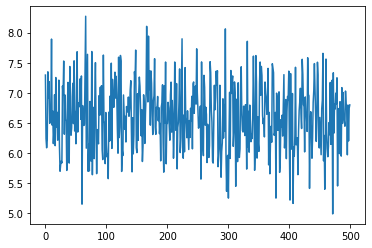

In [7]:
plt.plot(trace_gamma)

### クラスタリングの結果

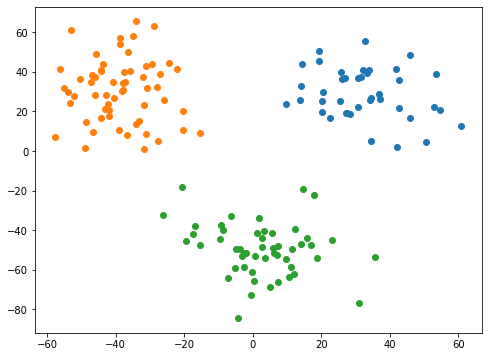

In [8]:
#グラフをプロット
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(data_X[pred_z == 2][:,0],data_X[pred_z == 2][:,1], 'o')
ax.plot(data_X[pred_z == 1][:,0],data_X[pred_z == 1][:,1], 'o')
ax.plot(data_X[pred_z == 0][:,0],data_X[pred_z == 0][:,1], 'o')
ax.plot(data_X[(pred_z != 0) & (pred_z != 1) & (pred_z != 2)][:,0],
        data_X[(pred_z != 0) & (pred_z != 1) & (pred_z != 2)][:,1], 'o')